In [21]:
%pip install -r ../../../requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# import plotly graphing libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [23]:
# define the error functions
def mean_absolute_percentage_error(t_true, y_predict):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    """
    t_true, y_predict = np.array(t_true), np.array(y_predict)
    return np.mean(np.abs((t_true - y_predict) / t_true)) * 100

In [24]:
# importing the dataset
data_frame = pd.read_csv("../../../data/file.csv")

In [25]:
#filter data only for the last 10 years
data_frame = data_frame[data_frame['Year'] >= 2010]

In [26]:
# Extract month number from Period column (M01 -> 1, M12 -> 12)
data_frame['Month'] = data_frame['Period'].str.extract('M(\\d+)').astype(int)

# Create a proper datetime index
data_frame['Date'] = pd.to_datetime(data_frame[['Year', 'Month']].assign(Day=1))

In [27]:
# plotting the data to understand the trends and other components
ts_data = data_frame.set_index('Date')['Value']

# Display information about the time series
print(f"Time series ranges from {ts_data.index.min().strftime('%Y-%m-%d')} to {ts_data.index.max().strftime('%Y-%m-%d')}")
print(f"Number of data points: {len(ts_data)}")
print(f"Min value: {ts_data.min()}, Max value: {ts_data.max()}, Mean value: {ts_data.mean():.2f}")

# Show the first and last few values
print("\nFirst few values:")
print(ts_data.head())
print("\nLast few values:")
print(ts_data.tail())

Time series ranges from 2010-01-01 to 2025-04-01
Number of data points: 184
Min value: 133.3, Max value: 357.652, Mean value: 233.10

First few values:
Date
2010-01-01    230.5
2010-02-01    223.6
2010-03-01    238.8
2010-04-01    251.7
2010-05-01    244.6
Name: Value, dtype: float64

Last few values:
Date
2024-12-01    315.277
2025-01-01    319.281
2025-02-01    326.443
2025-03-01    354.496
2025-04-01    350.272
Name: Value, dtype: float64


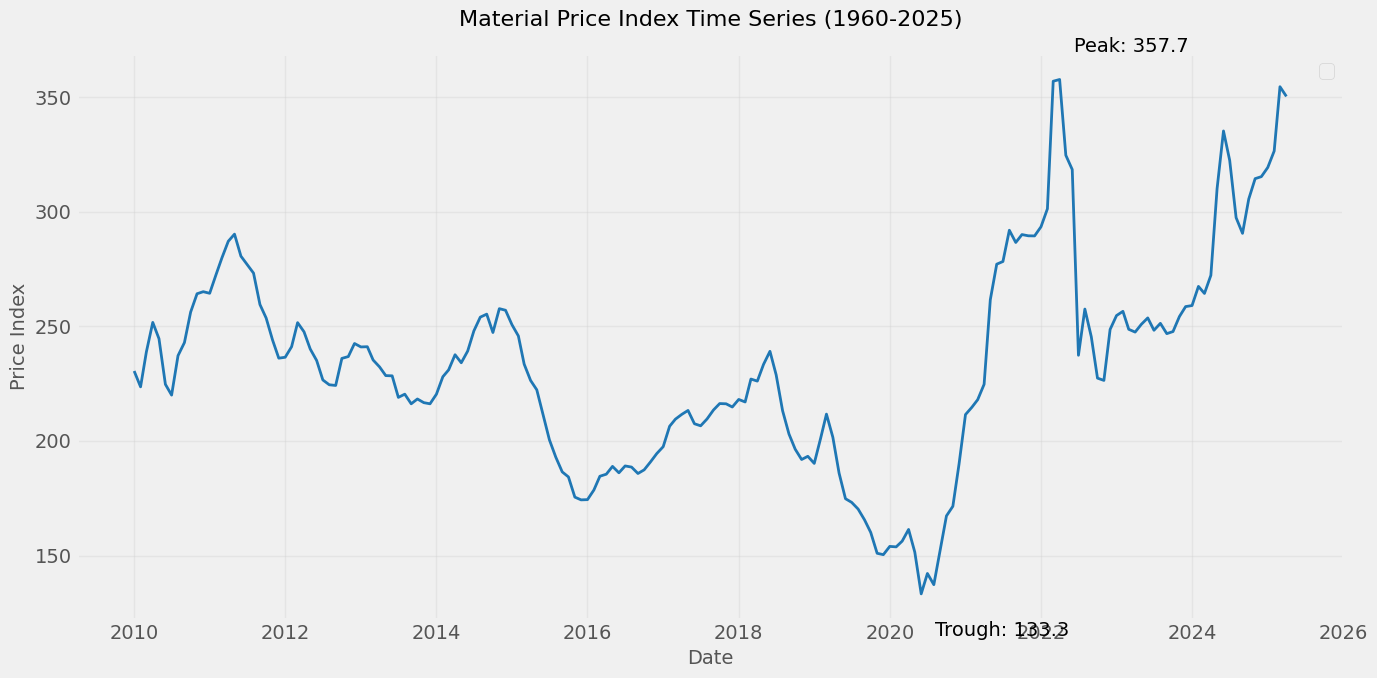

In [28]:
data_frame = data_frame.set_index("Label")

# Create a proper time series plot
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data.values, color='#1f77b4', linewidth=2)

# Enhance the plot with proper labels and formatting
plt.title('Material Price Index Time Series (1960-2025)', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price Index', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations for significant peaks or troughs
top_peak = ts_data.idxmax()
bottom_trough = ts_data.idxmin()

plt.annotate(f'Peak: {ts_data.max():.1f}', 
            xy=(top_peak, ts_data.max()),
            xytext=(10, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f'Trough: {ts_data.min():.1f}', 
            xy=(bottom_trough, ts_data.min()),
            xytext=(10, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.2'))

plt.tight_layout()
plt.show()

In [29]:
data_frame = data_frame.rename(columns={"Date": "ds",
                                        "Value": "y"})

In [30]:
data_frame.tail()

,Series ID,Year,Period,y,Month,ds
Label,,,,,,
2024 Dec,WPU102302,2024,M12,315.277,12,2024-12-01
2025 Jan,WPU102302,2025,M01,319.281,1,2025-01-01
2025 Feb,WPU102302,2025,M02,326.443,2,2025-02-01
2025 Mar,WPU102302,2025,M03,354.496,3,2025-03-01
2025 Apr,WPU102302,2025,M04,350.272,4,2025-04-01


In [31]:
# splitting the dataset into train and test sets
train_data = data_frame[data_frame['ds'] < '2023-01-01']
test_data = data_frame[data_frame['ds'] >= '2023-01-01']

In [32]:
# fitting the Prophet model using the training data
# TODO: Add more parameters to the model (hyper parameter tuning)
model = Prophet(seasonality_mode='additive')
model.fit(train_data)

12:45:33 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
model_test_forecast = model.predict(test_data)

In [34]:
model_test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01,273.662770,237.921236,309.277971,273.662770,273.662770,0.442864,0.442864,0.442864,0.442864,0.442864,0.442864,0.0,0.0,0.0,274.105634
1,2023-02-01,276.007266,236.806504,313.696756,275.957602,276.033662,1.964936,1.964936,1.964936,1.964936,1.964936,1.964936,0.0,0.0,0.0,277.972203
2,2023-03-01,278.124876,261.143878,335.049545,277.974192,278.229805,21.929513,21.929513,21.929513,21.929513,21.929513,21.929513,0.0,0.0,0.0,300.054389
3,2023-04-01,280.469372,259.634800,335.749452,280.223526,280.690585,17.902910,17.902910,17.902910,17.902910,17.902910,17.902910,0.0,0.0,0.0,298.372282
4,2023-05-01,282.738239,257.624991,331.566324,282.369652,283.082251,10.449577,10.449577,10.449577,10.449577,10.449577,10.449577,0.0,0.0,0.0,293.187816


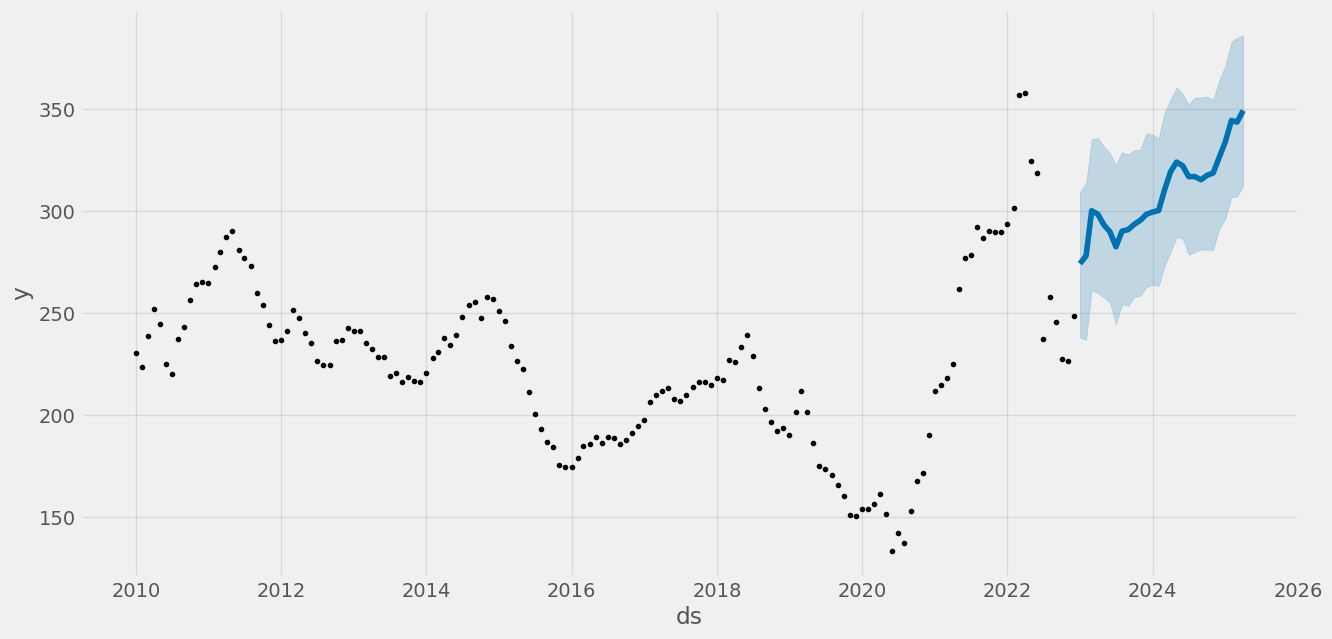

In [35]:
# plot the forecast
fig, ax = plt.subplots(figsize=(14, 7))
fig = model.plot(model_test_forecast, ax=ax)
plt.show()

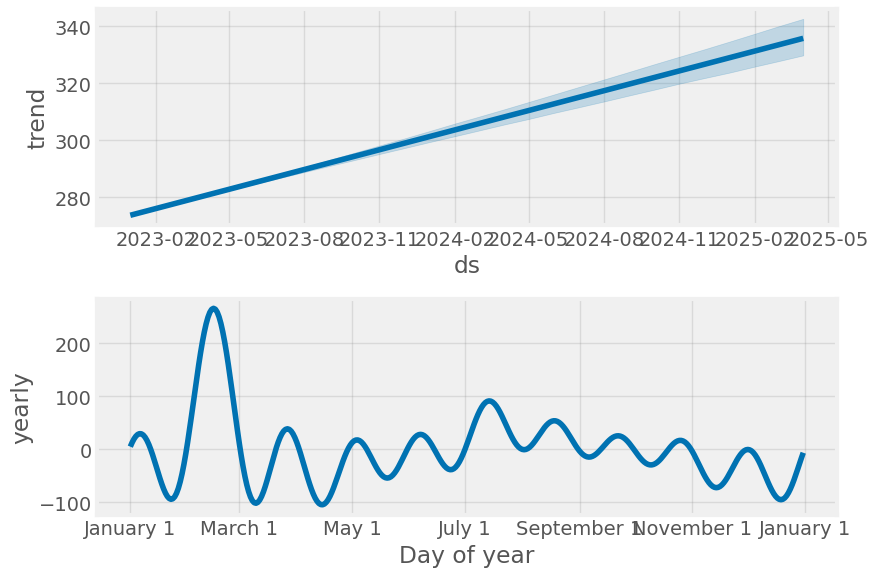

In [36]:
# plotting the forecast components
fig = model.plot_components(model_test_forecast)
plt.show()

In [37]:
#plotting the forecasted values against the actual values
fig = go.Figure()

# Add historical training data
fig.add_trace(go.Scatter(
    x=train_data['ds'],
    y=train_data['y'],
    mode='lines+markers',
    name='Historical Data',
    marker=dict(color='lightblue', size=4),
    line=dict(color='lightblue', width=1),
    hovertemplate='<b>Historical</b><br>Date: %{x}<br>Value: %{y:.2f}<extra></extra>'
))

# Add actual values
fig.add_trace(go.Scatter(
    x=test_data['ds'],
    y=test_data['y'],
    mode='markers',
    name='Actual Values',
    marker=dict(color='blue', size=8),
    hovertemplate='<b>Actual</b><br>Date: %{x}<br>Value: %{y:.2f}<extra></extra>'
))

# Add predicted values
fig.add_trace(go.Scatter(
    x=model_test_forecast['ds'],
    y=model_test_forecast['yhat'],
    mode='markers+lines',
    name='Predicted Values',
    marker=dict(color='red', size=6),
    line=dict(color='red', width=2),
    hovertemplate='<b>Predicted</b><br>Date: %{x}<br>Value: %{y:.2f}<extra></extra>'
))

# Add confidence intervals
fig.add_trace(go.Scatter(
    x=model_test_forecast['ds'],
    y=model_test_forecast['yhat_upper'],
    mode='lines',
    name='Upper Confidence',
    line=dict(color='rgba(255,0,0,0.2)', width=0),
    showlegend=False,
    hoverinfo='skip'
))

fig.add_trace(go.Scatter(
    x=model_test_forecast['ds'],
    y=model_test_forecast['yhat_lower'],
    mode='lines',
    name='Lower Confidence',
    line=dict(color='rgba(255,0,0,0.2)', width=0),
    fill='tonexty',
    fillcolor='rgba(255,0,0,0.2)',
    showlegend=False,
    hoverinfo='skip'
))

# Update layout
fig.update_layout(
    title='Prophet Model: Historical Data, Actual vs Predicted Values',
    xaxis_title='Date',
    yaxis_title='Value',
    width=1000,
    height=500,
    hovermode='x unified'
)

fig.show()